#Wheat Disease Image Recognition

## Module Imports

In [ ]:
#Data Download
from google.colab import drive

#File Shuffling
import os
import shutil

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#Data Handling
import numpy as np
import pandas as pd

#CNN
import tensorflow as tf
from keras.callbacks import EarlyStopping

## Data Import

Data wasn't able to be downloaded directly from Kaggle due to the size of the dataset. Instead, it was downloaded into Google Drive, mounted the drive and downloaded from there. To re-run and reproduce this notebook, either the same method will need to be repeated, or data download adjusted.

In [ ]:
#mount google drive to colab
drive.mount('/content/drive')

#Unzip data
!mkdir -p data
!unzip -q /content/drive/MyDrive/Portfolio_Datasets/wheat-plant-diseases.zip -d wheatdata/

Mounted at /content/drive


## Folder Reorganisation


**Problems**

The Kaggle dataset had a few issues needing correcting before a CNN could be run effectively.

1 - The dataset conained corrupted or ill-formatted images. Mostly from within the mildew subset, however it shoudln't be so many as to affect training.

2 - The dataset came pre-split into train/test/val directories. However the split ratio didn't hold enough images for testing or validation.

3 - To merge the folders so they could be re-split into a better ratio, sub-directories were named with inconsistent methods, some having test or val suffixes in the image labels, some with or without underscores.


**Solutions**

1 - 'Bad' images were found by using tf.image.decode_image to identify images which wouldn't work with the tf pipeline. These were removed from the dataset.

2 - All images were recombined into a singular collection holding subdirectories of diseases. These were then re-split using tf.

3 - A series of adjustments made to image names to create a standardised naming pattern before recombining files.

In [ ]:
#Identify and remove 'bad images' which have been causing errors in CNN

# Folders to check
folders = ['wheatdata/data/train', 'wheatdata/data/valid', 'wheatdata/data/test']

bad_images = []

for folder in folders:
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            try:
                # Try reading and decoding as RGB
                img = tf.io.read_file(img_path)
                img = tf.image.decode_image(img, channels=3)
            except Exception as e:
                print(f"Defective image found: {img_path}")
                bad_images.append(img_path)

#Delete defective images
for img_path in bad_images:
    try:
        os.remove(img_path)
        print(f"Deleted: {img_path}")
    except Exception as e:
        print(f"Failed to delete: {img_path} | {e}")

print(f"\nTotal defective images deleted: {len(bad_images)}")

Defective image found: wheatdata/data/train/Blast/blast_402.png
Defective image found: wheatdata/data/train/Blast/blast_394.png
Defective image found: wheatdata/data/train/Aphid/aphid_123.png
Defective image found: wheatdata/data/train/Aphid/aphid_289.png
Defective image found: wheatdata/data/train/Aphid/aphid_66.png
Defective image found: wheatdata/data/train/Mildew/mildew_766.png
Defective image found: wheatdata/data/train/Mildew/mildew_927.png
Defective image found: wheatdata/data/train/Mildew/mildew_828.png
Defective image found: wheatdata/data/train/Mildew/mildew_705.png
Defective image found: wheatdata/data/train/Mildew/mildew_976.png
Defective image found: wheatdata/data/train/Mildew/mildew_754.png
Defective image found: wheatdata/data/train/Mildew/mildew_988.png
Defective image found: wheatdata/data/train/Mildew/mildew_1024.png
Defective image found: wheatdata/data/train/Mildew/mildew_951.png
Defective image found: wheatdata/data/train/Mildew/mildew_803.png
Defective image foun

In [ ]:
#Merge, standardize and combine directories

#Base directories
base_dir = "wheatdata/data"
clean_dir = os.path.join(base_dir, "all_data_clean")
os.makedirs(clean_dir, exist_ok=True)

#Original splits
splits = ["train", "valid", "test"]

for split in splits:
    split_dir = os.path.join(base_dir, split)

    #Loop over all class folders in this split
    for class_folder in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_folder)
        if not os.path.isdir(class_path):
            continue  #skp irrelevant files

        #Strip '_test' or '_valid' suffix
        disease_name = class_folder.replace("_test", "").replace("_valid", "")

        #Standardize folder name: lowercase and replace spaces with underscores
        disease_name = disease_name.lower().strip().replace(" ", "_")

        #Create folder in clean_dir for this disease
        dest_folder = os.path.join(clean_dir, disease_name)
        os.makedirs(dest_folder, exist_ok=True)

        #Copy all images to the clean folder
        for img_file in os.listdir(class_path):
            src_file = os.path.join(class_path, img_file)
            dest_file = os.path.join(dest_folder, img_file)

            # Copy without overwriting existing files
            if not os.path.exists(dest_file):
                shutil.copy(src_file, dest_file)

# Optional: sanity check
for folder in sorted(os.listdir(clean_dir)):
    print(folder, len(os.listdir(os.path.join(clean_dir, folder))))

aphid 900
black_rust 576
blast 645
brown_rust 1321
common_root_rot 614
fusarium_head_blight 661
healthy 1050
leaf_blight 842
mildew 1101
mite 800
septoria 1144
smut 1360
stem_fly 234
tan_spot 770
yellow_rust 1351


## Data Split

Resplit data into 70:20:10 split.
70: Training
20: Testing
10: Validation

In [ ]:
#import data using tensorflow pipeline.
#Will split 70 training, 30 val. Then split the val data 20:10 for test:val.

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
VAL_SPLIT = 0.3

#Initially split only into train and test to make tf happy
train_data = tf.keras.utils.image_dataset_from_directory('wheatdata/data/all_data_clean',
                                                         shuffle = True,
                                                         batch_size = BATCH_SIZE,
                                                         image_size = IMG_SIZE,
                                                         validation_split = VAL_SPLIT,
                                                         subset = 'training',
                                                         seed = 42,
                                                         color_mode = 'rgb')

val_data = tf.keras.utils.image_dataset_from_directory('wheatdata/data/all_data_clean',
                                                       shuffle = True,
                                                       batch_size = BATCH_SIZE,
                                                       image_size = IMG_SIZE,
                                                       validation_split = VAL_SPLIT,
                                                       subset = 'validation',
                                                       seed = 42,
                                                       color_mode = 'rgb')

#Split val_data to create a test set
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take((2 * val_batches) // 3)
val_data = val_data.skip((2 * val_batches) // 3)

Found 13369 files belonging to 15 classes.
Using 9359 files for training.
Found 13369 files belonging to 15 classes.
Using 4010 files for validation.


In [ ]:
#Check import and data split has worked as desired
for images, labels in train_data.take(1):
  print(images.shape)

(32, 224, 224, 3)


## Autotune and Augmentation

In [ ]:
#Data Autotune and augmentation

#Add autotune to speed up training
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size = AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size = AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size = AUTOTUNE)

#Prepare Augmentation to increase training dataset size
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomBrightness(0.01),
        tf.keras.layers.RandomContrast(0.2)
        ])

## Transfer Learning CNN

The mode will be made using transfer lerning, using the MobilenetV2 pre-trained model to build from.

### MobileNet import and Image prep

In [ ]:
#Rescale pixel values to suit mobilenet
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


#Create Base Model - with Frozen layers
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

#convert image size
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

#Feature extraction
#Initially set model to un-trainable so it doesn't update weights from transfer
base_model.trainable = False
base_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(32, 7, 7, 1280)


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#Add layers relevant to our task

#Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

#Add layer to convert feature into a prediction
prediction_layer = tf.keras.layers.Dense(15, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

#Create model combining base transfer mdoel, + our unique layers used for our data

inputs = tf.keras.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

(32, 1280)
(32, 15)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Compilation and Evaluation

In [ ]:
#Compile model with Adam Optimizer
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer = adam, loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

#Set Epochs for initial evaluation
initial_epochs = 20
loss0, accuracy0 = model.evaluate(val_data)

print('Initial Loss: {:.2f}'.format(loss0))
print('Initial accuracy: {:.2f}'.format(accuracy0))

42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 538ms/step - accuracy: 0.0345 - loss: 3.4439
Initial Loss: 3.44
Initial accuracy: 0.03


### Training with Layers Frozen

In [ ]:
#Introduce Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5,
                               verbose = 0)

#Run Training
history = model.fit(train_data,
                    epochs = initial_epochs,
                    validation_data = val_data,
                    callbacks = early_stopping)

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 148s 468ms/step - accuracy: 0.1413 - loss: 2.8430 - val_accuracy: 0.4508 - val_loss: 1.8428
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.4632 - loss: 1.7638 - val_accuracy: 0.5590 - val_loss: 1.4458
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.5693 - loss: 1.4081 - val_accuracy: 0.6089 - val_loss: 1.2665
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6203 - loss: 1.2321 - val_accuracy: 0.6324 - val_loss: 1.1632
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6458 - loss: 1.1148 - val_accuracy: 0.6513 - val_loss: 1.0925
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6667 - loss: 1.0530 - val_accuracy: 0.6596 - val_loss: 1.0425
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.6825 - loss: 0.9872 - val_accuracy: 0.6725 - val_loss: 1.0021
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.7003 - loss: 0.9377 - v

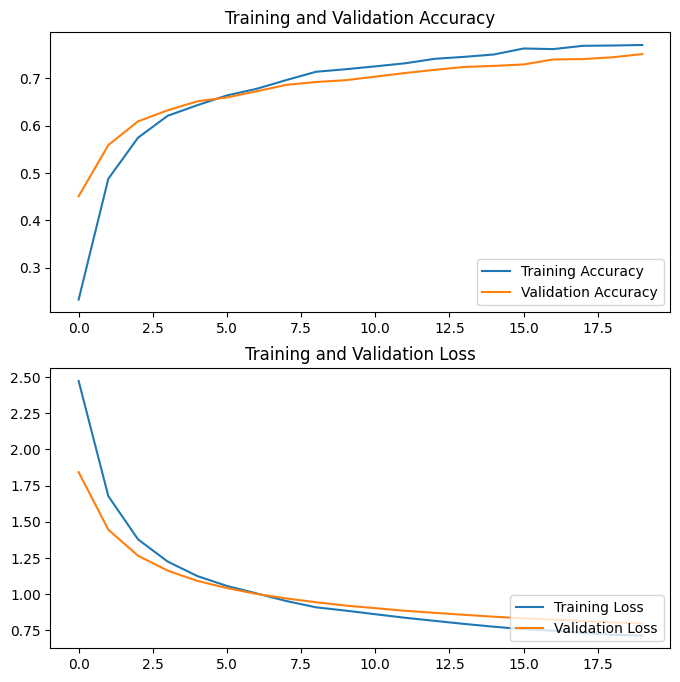

In [ ]:
#Visualise Training
plt.figure(figsize = (8,8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

### Further Training w/ Unfrozen Layers

In [ ]:
#Unfreeze top layers from MobileNet
base_model.trainable = True

for layer in base_model.layers[:105]:
  layer.trainable = False

In [ ]:
#Recompile model with unfrozen top layers and reduced LR
slower_lr = 0.00001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = slower_lr),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

Training Log - Track Record of how much training completed before plateauing.
- 20 Epochs - Frozen Layers
- 20 Epochs - First Tuning


In [ ]:
#Add more Epochs for tuning
#Set intial_epoch so it continues were previous training ended
#Will keep running training until hit plateau adding further Epochs and updating intitial_epoch to avoid re-training
tuning_epochs = 20
total_epochs = initial_epochs + tuning_epochs

history_tuning = model.fit(train_data, validation_data = val_data,
                           epochs = 50, initial_epoch = 40,
                           callbacks = early_stopping)

Epoch 41/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9895 - loss: 0.0802 - val_accuracy: 0.8427 - val_loss: 0.5504
Epoch 42/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9906 - loss: 0.0718 - val_accuracy: 0.8411 - val_loss: 0.5596
Epoch 43/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9929 - loss: 0.0644 - val_accuracy: 0.8427 - val_loss: 0.5604
Epoch 44/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9937 - loss: 0.0547 - val_accuracy: 0.8419 - val_loss: 0.5654
Epoch 45/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9942 - loss: 0.0500 - val_accuracy: 0.8434 - val_loss: 0.5705
Epoch 46/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9963 - loss: 0.0449 - val_accuracy: 0.8434 - val_loss: 0.5736


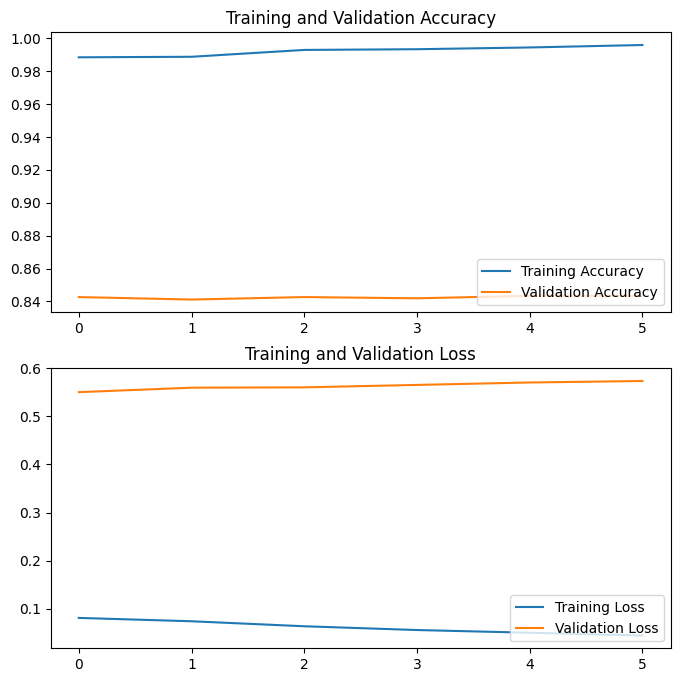

In [ ]:
#Visualise Training
plt.figure(figsize = (8,8))
plt.subplot(2, 1, 1)
plt.plot(history_tuning.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_tuning.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_tuning.history['loss'], label = 'Training Loss')
plt.plot(history_tuning.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

### Save Model

In [ ]:
#Save the model information
from tensorflow.keras.models import load_model

model.save('wheat_disease_recognition_model.keras')

In [ ]:
# Want to Reload model, create a model v_2, working on more unfrozen layers, and then re-train

## Test Model

Final test of the model to evaluate performance against unseen test data.

In [ ]:
#Reload trained model
model = load_model('wheat_disease_recognition_model.keras')

In [ ]:
#Test and Evaluate Model
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 389ms/step - accuracy: 0.8426 - loss: 0.5640
Test Accuracy: 0.844122052192688
Test Loss: 0.5363529324531555


The final model accomplished an accuracy of 84.26% for correct classification of 15 different wheat diseases. Next steps will include creating a model_v2, with a few more unfreezed layers and training further, seeing if accuracy can be improved further.

## Requirements Text

In [2]:

requirements = """
os
shutil
numpy
pandas
matplotlib
seaborn
tensorflow
keras
"""

with open('requirements.txt', 'w') as f:
  f.write(requirements)